In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import gc

In [2]:
from gensim.models.wrappers import LdaMallet
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from gensim.models.coherencemodel import CoherenceModel
import csv

In [3]:
with open('speeches-lemmatized-agg-ngrams-long.pkl', 'rb') as f:
    df = pickle.load(f)

# Exploring top topic p distributions

### Load files

140-topic LDA model

In [4]:
N = 140

with open(f'topic-models/doc-topics/lda_mallet_{N}_doc_topics.pkl', 'rb') as f:
    dt = pickle.load(f)
    
with open(f'topic-models/lda_mallet_{N}.pkl', 'rb') as f:
    lda = pickle.load(f)

In [5]:
dt.shape

(94713, 140)

In [6]:
def review_doc(ind, n_top_p=3, n_topics=5):
    print(f'doc id: {ind}', '\n')
    
    print(f'top {n_top_p} topic ps:', np.sum(np.sort(dt[ind])[::-1][:n_top_p]), '\n')

    print('Largest doc topic probs', np.sort(dt[ind])[::-1][:12], '\n')

    for i, topic_id in enumerate(np.argsort(dt[ind])[::-1][:n_topics]):
        print(np.around( np.sort(dt[ind])[::-1][i], 3 ), topic_id)
        print(lda.print_topic(topic_id))
        print('\r')

    print(df.iloc[ind].speech)

## Plot topic p distributions

In [7]:
# def old_topic_i_p(dt,i,j=None):
#     if j is not None:
#         return np.sum([topic_i_p(dt, n) for n in np.arange(i,j)], axis=0)
#     else:
#         return np.sort(dt, axis=1)[:, ::-1][:,i]

In [8]:
def topic_i_p(dt, n_topics, start=0):
        top_ps = np.sort(dt, axis=1)[:, ::-1][:, start : start + n_topics]
        return np.sum(top_ps, axis=1)

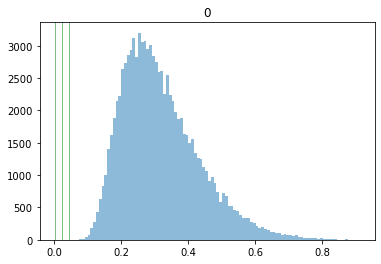

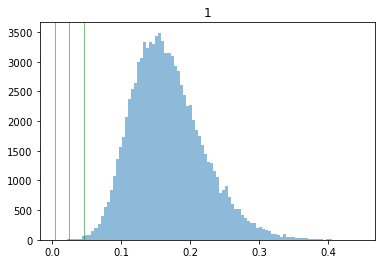

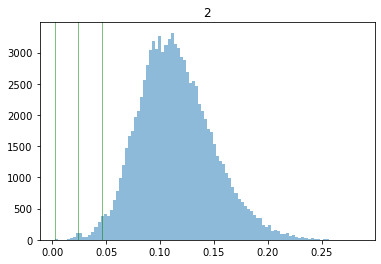

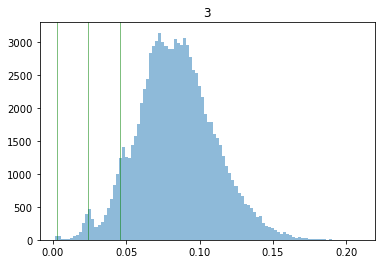

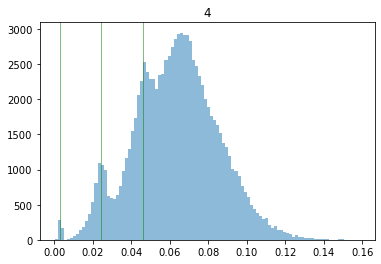

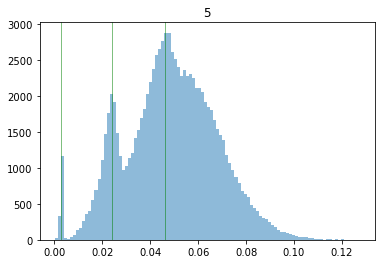

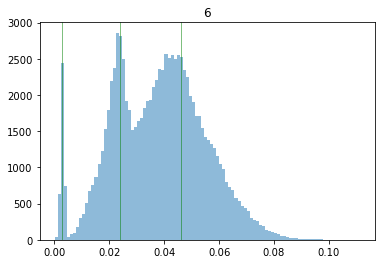

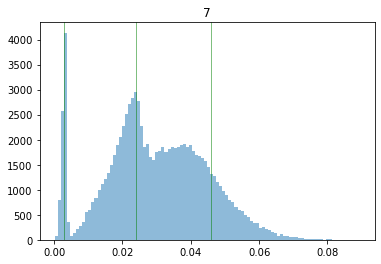

In [9]:
for i in range(8):
    plt.hist(topic_i_p(dt, n_topics=1, start=i), bins=100, alpha=0.5)
    plt.axvline(0.003, color='green', linewidth=0.5)
    plt.axvline(0.024, color='green', linewidth=0.5)
    plt.axvline(0.046, color='green', linewidth=0.5)
    plt.title(i)
    plt.show()

* changing shape of distribution (growing peaks around 0.02 & 0.04 - lda averages small amount of topic attention over many topics, so all end up with the around the same small value) 
* shape change visible in 2, strong in 3
* motivates decision to take sum of no more than top 2 topic probabilities

In [10]:
def get_suffix(n):
    if n==1:
        return 'st'
    elif n==2:
        return 'nd'
    elif n==3:
        return 'rd'
    else:
        return 'th'

In [11]:
def plot_top_p_hist(dt, top_p=2, bins=100, title='', figsize=(8,5)):
    
    plt.figure(figsize=figsize)
    
    for i in range(top_p):
        plt.hist(topic_i_p(dt, start=i, n_topics=1), bins=bins, alpha=0.5, label=f'{i}{get_suffix(i)}')
        
    plt.hist(topic_i_p(dt, start=0, n_topics=top_p), bins=bins, alpha=0.5, label=f'sum of top {top_p}')
    
    plt.xlabel(f'document topic probability')
    plt.ylabel('frequency')
    plt.legend(title='nth highest doc prob')
    plt.title(title)
#     plt.show()

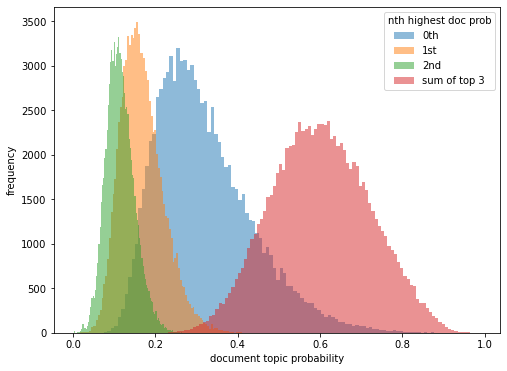

In [12]:
plot_top_p_hist(dt, 3, figsize=(8,6))

In [18]:
for i in np.linspace(0.4, 0.8, 5):
    print(i, len(np.where(topic_i_p(dt,3) > i)[0])/len(df))

0.4 0.9587701793840339
0.5 0.7932174041578242
0.6000000000000001 0.49667944210404064
0.7000000000000001 0.21246291427787103
0.8 0.051175656984785614


In [17]:
inds = np.where(topic_i_p(dt,3) < 0.6)[0]
print('no. speeches:', len(inds), '\n')
ind = np.random.choice(inds)
# ind = np.random.choice(np.where(Ieff > 40)[0])
review_doc(ind, 3)

no. speeches: 47671 

doc id: 64014 

top 3 topic ps: 0.599786570531944 

Largest doc topic probs [0.27014571 0.19694069 0.13270018 0.08876574 0.08854907 0.08850742
 0.04987763 0.02479723 0.01487966 0.01475863 0.00501536 0.00500352] 

0.27 101
0.079*"deal" + 0.037*"vote" + 0.037*"brexit" + 0.020*"prime_minister" + 0.016*"leave" + 0.014*"eu" + 0.012*"parliament" + 0.011*"withdrawal_agreement" + 0.010*"backstop" + 0.008*"european_union"

0.197 17
0.026*"gentleman" + 0.018*"argument" + 0.016*"view" + 0.014*"case" + 0.014*"matter" + 0.013*"thing" + 0.013*"accept" + 0.011*"make" + 0.011*"understand" + 0.010*"hope"

0.133 67
0.080*"law" + 0.034*"act" + 0.021*"legal" + 0.019*"court" + 0.019*"parliament" + 0.016*"convention" + 0.014*"human" + 0.013*"legislation" + 0.012*"principle" + 0.012*"european"

0.089 124
0.036*"proposal" + 0.035*"consultation" + 0.017*"gentleman" + 0.017*"set" + 0.015*"change" + 0.015*"process" + 0.014*"forward" + 0.013*"clear" + 0.011*"propose" + 0.011*"consult"

0.089

## Plot no. lemmas vs sum of topic probs

In [19]:
length = df.lemmas_ngrams.apply(len).values

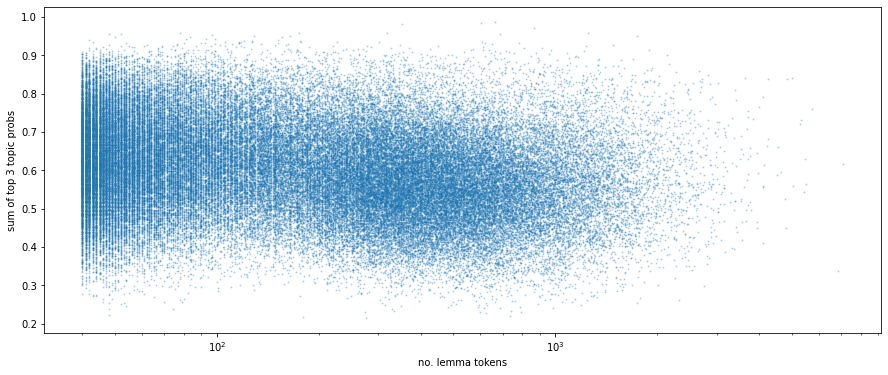

In [20]:
plt.figure(figsize=(15,6))
plt.scatter(length, topic_i_p(dt, start=0, n_topics=3), s=1, alpha=0.25)
plt.xlabel('no. lemma tokens')
plt.ylabel('sum of top 3 topic probs')
plt.xscale('log')
# plt.yscale('log')

# Filter speeches

## **Filter by top-3 topic sum threshold**

In [22]:
thresholds = np.linspace(0.4, 0.8, 5)
thresholds

array([0.4, 0.5, 0.6, 0.7, 0.8])

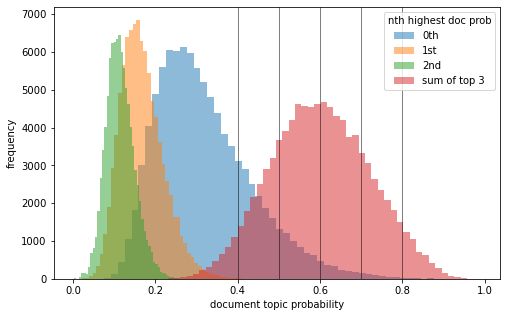

In [25]:
plot_top_p_hist(dt, 3, 50)
for t in thresholds:
    plt.axvline(t, linewidth=0.5, color='k')
plt.show()

In [28]:
filter_inds = {}

for t in thresholds:
    print(t)
    inds_t = np.where((topic_i_p(dt,3) > t))[0]
    filter_inds[t] = inds_t
    print(inds_t.shape[0])
    print(np.around(inds_t.shape[0]/dt.shape[0], 3))
    print('\r')

0.4
90808
0.959

0.5
75128
0.793

0.6000000000000001
47042
0.497

0.7000000000000001
20123
0.212

0.8
4847
0.051



In [30]:
with open('filter_inds.pkl', 'wb') as f:
    pickle.dump(filter_inds, f)

## Apply Filter (obsolete)

In [27]:
df_f = df.iloc[filter_inds]
dt_f = dt[filter_inds]

In [28]:
df_f

speech  \
date       heading                                           mnis_id                                                      
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] 1388     I join the Prime Minister and the Leader of th...   
                                                             1467     Before I go on to the tributes, I welcome the ...   
                                                             44       I congratulate my hon Friend the Member for Wa...   
                                                             54       I am sorry to interrupt my hon Friend when he ...   
           DISSOLUTION OF PARLIAMENT                         1581     What does my hon Friend think would have happe...   
...                                                                                                                 ...   
2019-11-05 Valedictory Debate                                167      It is a pleasure to follow the hon Member for ...   
                                                             3917     What a privilege it is to follow that heartfel...   
                                                             432      It seems only the blink of an eye since my hon...   
                                                             4455     On a point of order, Madam Deputy Speaker. As ...   
                                                             88       I was first elected to this place as the first...   

                                                                                                          lemmas_ngrams  
date       heading                                           mnis_id                                                     
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] 1388     [join, prime_minister, leader, opposition, pay...  
                                                             1467     [tribute, welcome, learn, member_camberwell_pe...  
                                                             44       [congratulate, watford, richard, harrington, t...  
                                                             54       [sorry, interrupt, flow, thing, immigrant, fam...  
           DISSOLUTION OF PARLIAMENT                         1581     [think, happen, callaghan, fall, election, cal...  
...                                                                                                                 ...  
2019-11-05 Valedictory Debate                                167      [pleasure_follow, north, devon, peter, heaton,...  
                                                             3917     [privilege, follow, heartfelt, speech, coincid...  
                                                             432      [blink, eye, friends, eale, north, stephen, po...  
                                                             4455     [order, madam_deputy_speaker, order, seek, gui...  
                                                             88       [elect, place, conservative, sit, constituency...  

[47042 rows x 2 columns]

In [32]:
df_f.sample().speech.values

array(['My hon Friend the Member for Christchurch (Mr Chope) and I do not always agree on matters relating to the European Union, but we generally agree on matters relating to human rights. He does sterling service in the Parliamentary Assembly of the Council of the Europe as chairman of the Committee on Legal Affairs and Human Rights.Many of us agree, across the spectrum of views on the European Union, that because all 27 members of the European Union are members of the Council of Europe and signatories to the European convention on human rights, the Fundamental Rights Agency represents unnecessary duplication. I had rather hoped that in the Council document on the multi-annual framework that is mentioned in the Bill we would find a distinction between the legitimate area of activity for European Union institutions and what is done in the general field of human rights. Article 2 of the document lists the thematic areas that the Fundamental Rights Agency will deal with during the multi

random sample of same size for comparison

In [33]:
# with open('filtered_dt.pkl', 'wb') as f:
#     pickle.dump(dt_f, f)
    
# with open('filtered_speeches.pkl', 'wb') as f:
#     pickle.dump(df_f, f)